In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 1
augment = 8

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(4)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 2000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': 1.,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=1_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'],
                    augment=augment)
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.0898471966795359e-05, 'std': 0.0010204081632653184, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 8.426528453197216e-06, 'std': 0.0010204081632653184, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 7.1627680150611464e-06, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 6.112593735830229e-06, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 5.995635747971194e-06, 'std': 0.0010204081632653184, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
losses=tensor([[3.7345e-05, 1.1813e-03, 1.1608e+01, 1.1349e+01]])
Elapsed time(grad):139.857
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):477.997
Fai

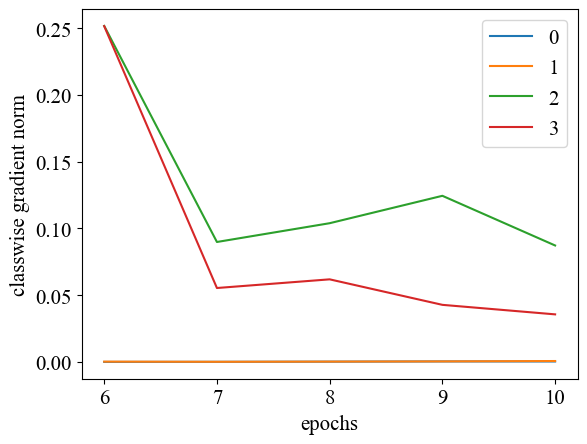

---------------------------- Task 3 -----------------------
losses=tensor([[2.9851e-04, 1.1967e-03, 3.3798e-01, 1.9966e-01, 1.2100e+01, 1.2621e+01]])
Elapsed time(grad):98.622
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):647.39
Fairness:[ 0.00000000e+00  6.34094062e-03  1.11022302e-16 -2.68111656e-02
  1.02350464e-02  1.02350528e-02]
len(updated_seq_indices)=27904
Elapsed time(etc):0.446
[11] Eval metrics for task 1 >> {'accuracy': 0.9038771015013936, 'loss': 0.0015527254723488016, 'std': 0.05999955048098532, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8217006293652621, 'loss': 0.0029924862473531756, 'std': 0.04942340164248982, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9338656352460888, 'loss': 0.0008048621764686853, 'std': 0.04373110609810671, 'EER': -1}
losses=tensor([[0.0021, 0.0024, 0.0023, 0.0021, 0.0824, 0.2834]])
Elapsed time(grad):97.828
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):542.7

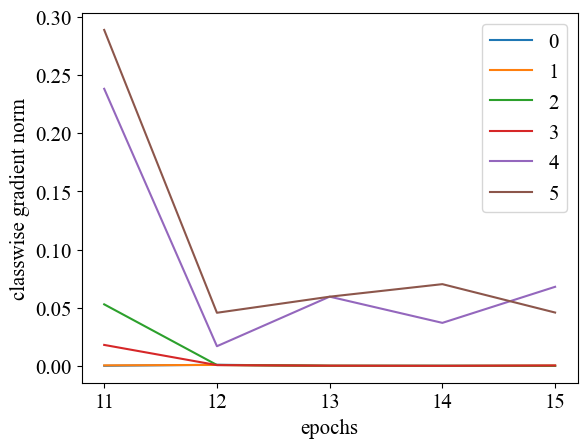

---------------------------- Task 4 -----------------------
losses=tensor([[1.1941e-04, 1.8715e-04, 2.5248e-04, 2.5094e-04, 3.5840e-01, 6.6086e-01,
         1.3876e+01, 1.2404e+01]])
Elapsed time(grad):114.696
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):815.444
Fairness:[ 0.05193327  0.12247569  0.         -0.14208541 -0.01169348  0.
 -0.01031526 -0.01031509]
len(updated_seq_indices)=30848
Elapsed time(etc):0.405
[16] Eval metrics for task 1 >> {'accuracy': 0.8854872786118853, 'loss': 0.002158440413486309, 'std': 0.07222197248943629, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.7575869214828459, 'loss': 0.004822918238532415, 'std': 0.09125028781947958, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.9022928406382142, 'loss': 0.0014019160190539529, 'std': 0.02336907382207082, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.9681140995751525, 'loss': 0.0004404305301284022, 'std': 0.004648546339244386, 'EER': -1}
losses=tenso

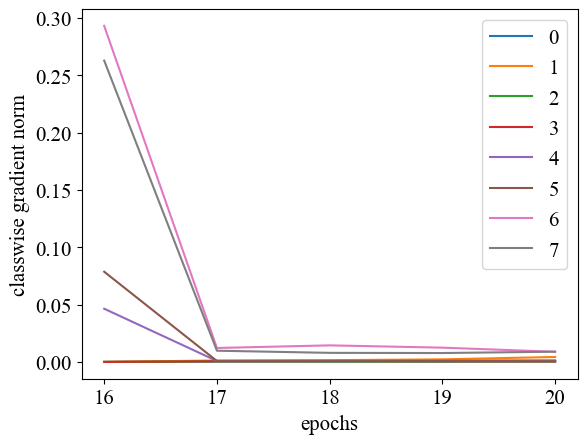

---------------------------- Task 5 -----------------------
losses=tensor([[1.0454e-03, 1.0765e-02, 1.1175e-03, 1.3836e-03, 4.9216e-03, 2.1325e-03,
         2.3623e-01, 1.0337e-01, 1.4045e+01, 1.4173e+01]])
Elapsed time(grad):119.946
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):1031.36
Fairness:[ 0.09419346  0.17508273  0.03505906  0.         -0.25016029  0.
  0.          0.         -0.02708792 -0.02708781]
len(updated_seq_indices)=32384
Elapsed time(etc):0.536
[21] Eval metrics for task 1 >> {'accuracy': 0.8515845545266565, 'loss': 0.002942723951722995, 'std': 0.08321720758788098, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.6859956635198403, 'loss': 0.0073705386228122395, 'std': 0.09985704965845421, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.7605120875307096, 'loss': 0.0043477039772265745, 'std': 0.04666280036166698, 'EER': -1}
[21] Eval metrics for task 4 >> {'accuracy': 0.899265249425278, 'loss': 0.0015536726106329627, 'std

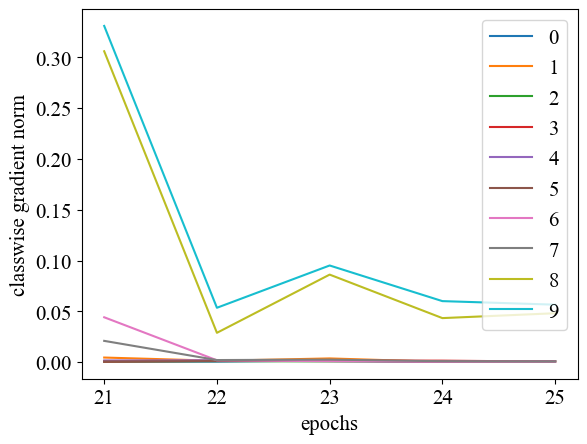

final avg-acc 0.8369821329212612
final avg-forget 0.12736811604915574


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
g = algorithm.grad_calculation_time
o = algorithm.optim_time
e = algorithm.etc_prepare_time
t = algorithm.overall_training_time


for task in range(2, 6):
    print(np.round(np.sum(list(g[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(o[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(e[task].values())), 4), end="\t")
print()
for task in range(2, 6):
    print(np.round(np.sum(list(t[task])), 4), end="\t")


674.9188	497.4371	577.7241	584.1262	
2782.6119	3067.7259	4464.0573	5406.5247	
2.9253	2.4319	2.4129	2.666	
3473.0124	3580.5147	5053.4102	6005.1282	

In [7]:
for task in range(2, 6):
    print(np.round(np.mean(list(o[task].values())), 4), end="\t")


556.5224	613.5452	892.8115	1081.3049	

In [8]:
num_class_per_task = 2
num_epochs = params['epochs_per_task']

t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = dict()
    groupwise_expected_loss[i] = dict()

for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            groupwise_true_loss[i][(task-1)*num_epochs+epoch] = tl
            groupwise_expected_loss[i][(task-1)*num_epochs+epoch] = el
            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


KeyError: 1

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][ce], end='\t')
    print()


0.061	0.1025	0.0234	0.0036	0.0007	0.0011	0.0175	0.0182	0.0132	0.008	0.0031	0.0255	0.011	0.0102	0.009	0.0014	0.0378	0.0089	0.0077	0.0057	
0.0701	0.0398	0.0237	0.0088	0.0028	0.0017	0.0261	0.0144	0.0128	0.0096	0.0023	0.0527	0.017	0.0165	0.0158	0.009	0.1252	0.0424	0.037	0.0148	
2.9677	0.8449	0.3812	0.2719	0.2858	0.3876	0.0688	0.0354	0.012	0.006	0.0506	0.1063	0.0282	0.0162	0.012	0.0093	0.0478	0.0302	0.0218	0.0131	
3.2105	0.8068	0.3248	0.2351	0.2427	0.3382	0.2972	0.2505	0.1081	0.0485	0.0109	0.0659	0.0296	0.0297	0.0166	0.0321	0.0993	0.0692	0.0379	0.0226	
					4.2689	1.3106	0.4138	0.2787	0.2584	0.2605	0.2353	0.0496	0.0228	0.0229	0.1874	0.2875	0.1445	0.0939	0.0579	
					4.3382	1.2363	0.5128	0.3526	0.3053	0.5551	0.1915	0.0441	0.0271	0.022	0.0566	0.1439	0.0721	0.0334	0.0252	
										5.0916	0.714	0.3528	0.3032	0.2622	0.4555	0.1048	0.0538	0.0443	0.032	
										4.4045	0.7462	0.2959	0.2504	0.2264	0.2874	0.2569	0.1955	0.1127	0.0906	
															4.5102	0.5851	0.3166	0.2588	0.2662	
														

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][ce], end='\t')
    print()


0.2682	0.633	0.2963	0.1669	0.1563	-0.1318	0.299	0.3281	0.4356	0.2688	-0.068	0.04	0.1105	0.1005	0.0881	-0.097	-0.0054	0.0756	0.1172	0.0793	
0.2373	0.5249	0.2711	0.1669	0.1563	-0.1542	0.004	0.0293	0.0479	0.064	-0.1372	0.0444	0.0706	0.0753	0.0802	-0.1469	0.247	0.3011	0.259	0.2234	
5.4838	0.7428	0.2837	0.1669	0.1563	0.3991	0.4048	0.2805	0.2181	0.1644	0.2698	0.4847	0.343	0.243	0.278	-0.0431	0.1092	0.2519	0.259	0.2239	
6.0146	0.6335	0.2837	0.1669	0.1563	0.427	0.9267	0.7672	0.6069	0.386	-0.0768	0.0839	0.159	0.1378	0.1183	-0.0442	0.4786	0.4413	0.4013	0.3076	
					7.4975	0.952	-0.0	-0.0	-0.0	0.2121	0.9034	0.3876	0.3622	0.208	0.2583	0.5918	0.5706	0.4596	0.338	
					8.7219	1.3406	0.2777	-0.0	0.0432	0.4137	0.5628	0.2552	0.1838	0.1736	0.0315	0.4312	0.4026	0.3156	0.3552	
										10.8094	0.4632	0.0	0.0	0.0	0.4621	0.2976	0.2989	0.259	0.2239	
										7.7241	0.3997	-0.0	-0.0	-0.0	0.1446	0.8036	0.7165	0.5192	0.4874	
															10.5369	0.4693	0.0	-0.0	0.0	
															10.7059	0.6274	0.0	0.0	0.0

In [ ]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9129834042728595
EER:0.0388356921592929
std:0.05572399535921074
